In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./backend')
import numpy as np
import pandas as pd

import sglm
import sglm_cv
import sglm_pp
import sglm_test

In [3]:
df = pd.read_csv('../C39v2_sampleDesignMat.csv').drop('Unnamed: 0', axis=1).drop('index', axis=1)

In [4]:
with pd.option_context('max_columns',100):
    display(df)

,nTrial,iBlock,iTrial,iOccurrence,iState_start,iState_end,analog1,analog2,CuePenalty,ENLPenalty,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,Reward,post,bl0,bl1,bl2,bl3,bl4,bl5,bl6,r-5,r-4,r-3,r-2,r-1,r0,r1,r2,r3,r4,r5,grnL
0,4.0,1.0,0.0,0.0,23.0,29.0,1123.0,2744.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,921.93774
1,4.0,1.0,0.0,1.0,29.0,30.0,229.0,5.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,950.58765
2,4.0,1.0,0.0,2.0,30.0,30.0,229.0,6.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,944.09120
3,4.0,1.0,0.0,3.0,30.0,30.0,1123.0,2753.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,948.26196
4,4.0,1.0,0.0,4.0,30.0,30.0,1122.0,2746.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,945.38464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234923,239.0,13.0,0.0,1128.0,21.0,14.0,229.0,5.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,854.06330
234924,239.0,13.0,0.0,1129.0,14.0,24.0,231.0,7.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,854.59150
234925,239.0,13.0,0.0,1130.0,24.0,25.0,1123.0,2748.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,854.45250
234926,239.0,13.0,0.0,1131.0,25.0,27.0,1122.0,2746.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,855.09950


In [153]:
key_cols = [
    'nTrial', # trial ID
    'iBlock', # block number within session
    'CuePenalty', # lick during cue period (no directionality yet, so binary 0,1)
    'ENLPenalty', # lick during ENL period (no directionality yet, 0,1)
    'Select', # binary selection lick
    'Consumption', # consumption period (from task perspective)
    'TO', # timeout trial
    'responseTime', # task state cue to selection window
    'ENL', # task state ENL window
    'Cue', # task state Cue window
    'decision', # choice lick direction (aligned to select but with directionality -1,1)
    'switch', # switch from previous choice on selection (-1,1)
    'selR', # select reward (-1,1) aligned to selection
    'selHigh', # select higher probability port (-1,1)
    'Reward', # reward vs no reward during consumption period (-1,1)
    'post', # log-odds probability
    'grnL', # photometry response
]

dfkc = df[key_cols].copy()
dfkc = dfkc.replace('False', 0).astype(float)
dfkc = dfkc*1

dfkc = dfkc.dropna(thresh=12)
# dfkc = dfkc.fillna(0)

with pd.option_context('max_columns',100):
    display(dfkc)

,nTrial,iBlock,CuePenalty,ENLPenalty,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,Reward,post,grnL
0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.93774
1,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,950.58765
2,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.09120
3,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,948.26196
4,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,945.38464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234923,239.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.06330
234924,239.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.59150
234925,239.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.45250
234926,239.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,855.09950


In [163]:
# predictors = key_cols[4:7]
predictors = key_cols[4:]
prd = dfkc[predictors]
prd

resp = dfkc['grnL']

In [164]:
prd_sft = sglm_pp.timeshift_multiple(prd, shift_amt_list=[0, 1])
with pd.option_context('max_columns', 1000):
    display(prd_sft)

,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,Reward,post,grnL,Select_1,Consumption_1,TO_1,responseTime_1,ENL_1,Cue_1,decision_1,switch_1,selR_1,selHigh_1,Reward_1,post_1,grnL_1
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.93774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,950.58765,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.93774
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.09120,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,950.58765
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,948.26196,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.09120
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,945.38464,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,948.26196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.06330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,853.97560
234924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.59150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.06330
234925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.45250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.59150
234926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,855.09950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.45250


In [165]:
prd_sft['Consumption_diff'] = sglm_pp.diff(prd_sft['Consumption'])
prd_sft

,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,...,ENL_1,Cue_1,decision_1,switch_1,selR_1,selHigh_1,Reward_1,post_1,grnL_1,Consumption_diff
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.93774,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,950.58765,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.09120,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,948.26196,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,853.97560,0.0
234924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.06330,0.0
234925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.59150,0.0
234926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.45250,0.0


In [166]:
prd_sft['grnL'] = resp
prd_sft

,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,...,ENL_1,Cue_1,decision_1,switch_1,selR_1,selHigh_1,Reward_1,post_1,grnL_1,Consumption_diff
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.93774,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,950.58765,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.09120,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,948.26196,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,853.97560,0.0
234924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.06330,0.0
234925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.59150,0.0
234926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.45250,0.0


In [229]:
prd_sft.columns

Index(['Select', 'Consumption', 'TO', 'responseTime', 'ENL', 'Cue', 'decision',
       'switch', 'selR', 'selHigh', 'Reward', 'post', 'grnL', 'Select_1',
       'Consumption_1', 'TO_1', 'responseTime_1', 'ENL_1', 'Cue_1',
       'decision_1', 'switch_1', 'selR_1', 'selHigh_1', 'Reward_1', 'post_1',
       'grnL_1', 'Consumption_diff'],
      dtype='object')

In [168]:
# prd_sft = prd_sft.fillna(0)

In [169]:
prd_sft.dtypes

Select              float64
Consumption         float64
TO                  float64
responseTime        float64
ENL                 float64
Cue                 float64
decision            float64
switch              float64
selR                float64
selHigh             float64
Reward              float64
post                float64
grnL                float64
Select_1            float64
Consumption_1       float64
TO_1                float64
responseTime_1      float64
ENL_1               float64
Cue_1               float64
decision_1          float64
switch_1            float64
selR_1              float64
selHigh_1           float64
Reward_1            float64
post_1              float64
grnL_1              float64
Consumption_diff    float64
dtype: object

In [170]:
prd_sft[['grnL','grnL_1']]

,grnL,grnL_1
0,921.93774,NaN
1,950.58765,921.93774
2,944.09120,950.58765
3,948.26196,944.09120
4,945.38464,948.26196
...,...,...
234923,854.06330,853.97560
234924,854.59150,854.06330
234925,854.45250,854.59150
234926,855.09950,854.45250


In [171]:
resp.values

array([921.93774, 950.58765, 944.0912 , ..., 854.4525 , 855.0995 ,
       854.3872 ])

In [230]:
tmp = prd_sft[['grnL', 'grnL_1']].dropna()

tmp2 = prd_sft.dropna()
tmp2

,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,...,ENL_1,Cue_1,decision_1,switch_1,selR_1,selHigh_1,Reward_1,post_1,grnL_1,Consumption_diff
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.93774,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,950.58765,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.09120,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,948.26196,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,945.38464,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,853.97560,0.0
234924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.06330,0.0
234925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.59150,0.0
234926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.45250,0.0


In [231]:
glm = sglm.GLM('Normal', verbose=False, alpha=0.05,
            max_iter=1000, learning_rate=2e-8, score_metric='pseudo_R2',
            reg_lambda=1e-3, eta=4.0)

glm.fit(tmp[['grnL_1']].values, tmp['grnL'].values)

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(


In [232]:
glm.model.predict(prd_sft[['grnL_1']].values)

array([933.33884696, 944.33113455, 943.18680866, ..., 851.82260088,
       852.07686719, 852.04244199])

In [233]:
glm.coef_

array([-0.        , -0.        ,  0.0300319 ,  0.01672741, -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.00213858, -0.        ,  0.49976704, -0.        , -0.        ,
        0.00335997, -0.        , -0.        , -0.        , -0.0411782 ,
        0.        , -0.        , -0.        ,  0.03126289, -0.00174722,
        0.49699979, -0.        ])

In [236]:
import matplotlib.pyplot as plt
plt.plot(glm.model.predict(prd_sft[['grnL_1']].fillna(0).values), alpha = 0.3, color='g')
plt.plot(prd_sft['grnL'].values, alpha = 0.3, color='r')


ValueError: shapes (234928,1) and (27,) not aligned: 1 (dim 1) != 27 (dim 0)

In [228]:
prd_sft

,Select,Consumption,TO,responseTime,ENL,Cue,decision,switch,selR,selHigh,...,ENL_1,Cue_1,decision_1,switch_1,selR_1,selHigh_1,Reward_1,post_1,grnL_1,Consumption_diff
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,921.93774,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,950.58765,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,944.09120,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,948.26196,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,853.97560,0.0
234924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.06330,0.0
234925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.59150,0.0
234926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,854.45250,0.0


In [184]:
from sklearn.linear_model import LinearRegression
glm3 = LinearRegression()
glm3.fit(prd_sft[['grnL_1']].fillna(0).values, prd_sft['grnL'].values)

LinearRegression()

In [185]:
pred = glm3.predict(prd_sft[['grnL_1']].fillna(0).values)
true = prd_sft['grnL'].values

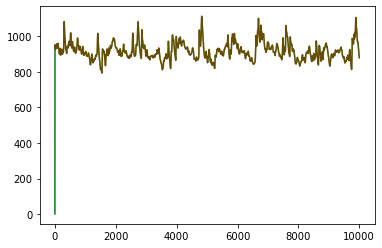

In [188]:
import matplotlib.pyplot as plt
plt.plot(pred[:10000], color='g')
plt.plot(true[:10000], alpha = 0.4, color='r')

In [187]:
np.concatenate([pred[:,None], true[:,None]], axis=-1)

array([[  1.55965314, 921.93774   ],
       [921.88381992, 950.58765   ],
       [950.48358692, 944.0912    ],
       ...,
       [854.65544915, 854.4525    ],
       [854.51669243, 855.0995    ],
       [855.16256005, 854.3872    ]])